<a href="https://colab.research.google.com/github/vadhri/distibuted-optimization/blob/main/ADMM/consensus_cuda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

CSV file saved as synthetic_sine_signals.csv


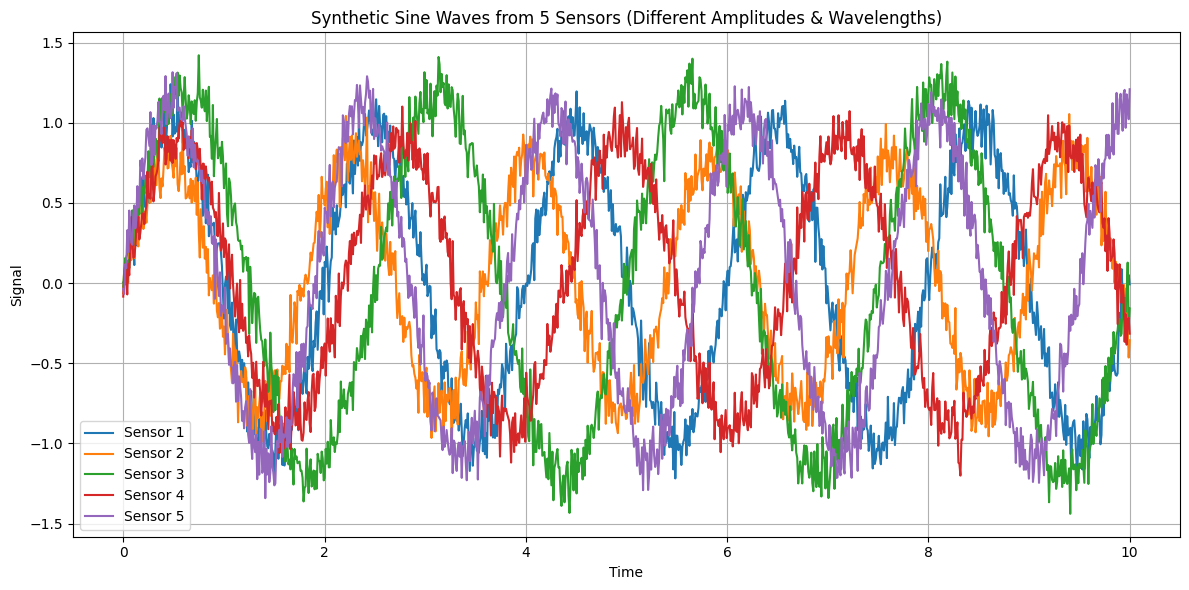

In [75]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Time vector
t = np.linspace(0, 10, 1000)

# Number of sensors (5)
N = 5

# Different amplitudes and wavelengths
amplitudes = [1.0, 0.8, 1.2, 0.9, 1.1]
wavelengths = [2.0, 1.8, 2.5, 2.2, 1.9]

# Noise level
noise_std = 0.1

# DataFrame to store signals
df = pd.DataFrame({'time': t})

# Generate signals and store
for i in range(N):
    signal = amplitudes[i] * np.sin(2 * np.pi / wavelengths[i] * t)
    signal += np.random.normal(0, noise_std, size=len(t))
    df[f'sensor_{i+1}'] = signal

# Save to CSV
df.to_csv('synthetic_sine_signals.csv', index=False)
print('CSV file saved as synthetic_sine_signals.csv')

# Plot signals
plt.figure(figsize=(12, 6))
for i in range(N):
    plt.plot(t, df[f'sensor_{i+1}'], label=f'Sensor {i+1}')
plt.xlabel('Time')
plt.ylabel('Signal')
plt.title('Synthetic Sine Waves from 5 Sensors (Different Amplitudes & Wavelengths)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [76]:
%%writefile sine.cu
#include <iostream>
#include <fstream>
#include <vector>
#include <cmath>
#include <cuda_runtime.h>

#define NODES 5
#define T 1000
#define ADMM_ITERS 200
#define LOCAL_ITERS 500
#define LR 0.001f
#define RHO 1.0f

__device__ float sine(float x) {
    return sinf(x);
}

__device__ void compute_gradients(float A, float lambda, float* y, int T_local, float* grad_A, float* grad_lambda) {
    float sum_grad_A = 0.0f;
    float sum_grad_lambda = 0.0f;
    for (int t = 0; t < T_local; t++) {
        float two_pi_over_lambda = 2.0f * 3.1415926f / lambda;
        float angle = two_pi_over_lambda * t;
        float sin_val = sine(angle);
        float pred = A * sin_val;
        float error = pred - y[t];
        sum_grad_A += 2.0f * error * sin_val;
        sum_grad_lambda += 2.0f * error * A * (two_pi_over_lambda * t) * cosf(angle) / lambda;
    }
    *grad_A = sum_grad_A;
    *grad_lambda = sum_grad_lambda;
}

__global__ void local_update_kernel(float* x_d, float* u_d, float* z_d, float* y_d, int T_local, float rho, float lr) {
    int idx = threadIdx.x + blockDim.x * blockIdx.x;
    if (idx >= NODES) return;

    float* y = &y_d[idx * T_local];
    float A = x_d[idx * 2 + 0];
    float lambda = x_d[idx * 2 + 1];
    float uA = u_d[idx * 2 + 0];
    float uLambda = u_d[idx * 2 + 1];
    float zA = z_d[0];
    float zLambda = z_d[1];

    for (int iter = 0; iter < LOCAL_ITERS; iter++) {
        float grad_A, grad_lambda;
        compute_gradients(A, lambda, y, T_local, &grad_A, &grad_lambda);

        grad_A += rho * (A - zA + uA);
        grad_lambda += rho * (lambda - zLambda + uLambda);

        A -= lr * grad_A;
        lambda -= lr * grad_lambda;

        lambda = fmaxf(lambda, 10.0f);  // avoid near-zero wavelength
    }

    x_d[idx * 2 + 0] = A;
    x_d[idx * 2 + 1] = lambda;
}

__global__ void dual_update_kernel(float* x_d, float* u_d, float* z_d) {
    int idx = threadIdx.x + blockDim.x * blockIdx.x;
    if (idx >= NODES) return;

    float A = x_d[idx * 2 + 0];
    float lambda = x_d[idx * 2 + 1];
    float zA = z_d[0];
    float zLambda = z_d[1];

    u_d[idx * 2 + 0] += A - zA;
    u_d[idx * 2 + 1] += lambda - zLambda;
}

void global_z_update(float* x_h, float* u_h, float* z_h) {
    float sumA = 0.0f, sumLambda = 0.0f;
    for (int i = 0; i < NODES; i++) {
        sumA += x_h[i * 2 + 0] + u_h[i * 2 + 0];
        sumLambda += x_h[i * 2 + 1] + u_h[i * 2 + 1];
    }
    z_h[0] = sumA / NODES;
    z_h[1] = sumLambda / NODES;
}

void read_csv_signals(const std::string& filename, float* y_h) {
    std::ifstream file(filename);
    if (!file.is_open()) {
        std::cerr << "Failed to open CSV file." << std::endl;
        exit(1);
    }

    std::string line;
    getline(file, line); // skip header
    int t = 0;
    while (getline(file, line) && t < T) {
        size_t pos = 0;
        pos = line.find(',') + 1; // skip time column

        for (int sensor = 0; sensor < NODES; sensor++) {
            size_t next_pos = line.find(',', pos);
            if (next_pos == std::string::npos)
                next_pos = line.length();
            std::string token = line.substr(pos, next_pos - pos);
            y_h[sensor * T + t] = std::stof(token);
            pos = next_pos + 1;
        }
        t++;
    }
    file.close();
}

int main() {
    float y_h[NODES * T];
    read_csv_signals("synthetic_sine_signals.csv", y_h);

    float x_h[NODES * 2];
    float u_h[NODES * 2] = {0};
    float z_h[2] = {1.0f, 50.0f};

    for (int i = 0; i < NODES; i++) {
        x_h[i * 2 + 0] = 1.0f;
        x_h[i * 2 + 1] = 50.0f;
    }

    float *x_d, *u_d, *z_d, *y_d;
    cudaMalloc(&x_d, sizeof(float) * NODES * 2);
    cudaMalloc(&u_d, sizeof(float) * NODES * 2);
    cudaMalloc(&z_d, sizeof(float) * 2);
    cudaMalloc(&y_d, sizeof(float) * NODES * T);

    cudaMemcpy(y_d, y_h, sizeof(float) * NODES * T, cudaMemcpyHostToDevice);

    dim3 threads(32);
    dim3 blocks((NODES + threads.x - 1) / threads.x);

    for (int iter = 0; iter < ADMM_ITERS; iter++) {
        cudaMemcpy(x_d, x_h, sizeof(float) * NODES * 2, cudaMemcpyHostToDevice);
        cudaMemcpy(u_d, u_h, sizeof(float) * NODES * 2, cudaMemcpyHostToDevice);
        cudaMemcpy(z_d, z_h, sizeof(float) * 2, cudaMemcpyHostToDevice);

        local_update_kernel<<<blocks, threads>>>(x_d, u_d, z_d, y_d, T, RHO, LR);
        cudaDeviceSynchronize();

        cudaMemcpy(x_h, x_d, sizeof(float) * NODES * 2, cudaMemcpyDeviceToHost);
        cudaMemcpy(u_h, u_d, sizeof(float) * NODES * 2, cudaMemcpyDeviceToHost);

        global_z_update(x_h, u_h, z_h);

        cudaMemcpy(z_d, z_h, sizeof(float) * 2, cudaMemcpyHostToDevice);
        dual_update_kernel<<<blocks, threads>>>(x_d, u_d, z_d);
        cudaDeviceSynchronize();

        if (iter % 10 == 0) {
            std::cout << "Iteration " << iter << ": A = " << z_h[0] << ", Lambda = " << z_h[1] << std::endl;
        }
    }

    std::cout << "Final Parameters: Amplitude = " << z_h[0] << ", Lambda = " << z_h[1] << std::endl;

    // Save CSV for Python plotting
    std::ofstream out("admm_estimated_vs_original.csv");
    out << "t,estimated";
    for (int sensor = 1; sensor <= NODES; sensor++) {
        out << ",sensor_" << sensor;
    }
    out << std::endl;

    for (int t = 0; t < T; t++) {
        float angle = 2.0f * 3.1415926f / z_h[1] * t;
        float estimated = z_h[0] * sin(angle);
        out << t << "," << estimated;
        for (int sensor = 0; sensor < NODES; sensor++) {
            out << "," << y_h[sensor * T + t];
        }
        out << std::endl;
    }
    out.close();

    cudaFree(x_d);
    cudaFree(u_d);
    cudaFree(z_d);
    cudaFree(y_d);

    return 0;
}


Overwriting sine.cu


In [77]:
!nvcc -gencode arch=compute_75,code=sm_75 sine.cu -o sine
!time ./sine

Iteration 0: A = -0.00239059, Lambda = 49.9814
Iteration 10: A = -0.000852261, Lambda = 49.6293
Iteration 20: A = -0.000875654, Lambda = 49.5295
Iteration 30: A = -0.000893061, Lambda = 49.5054
Iteration 40: A = -0.000894755, Lambda = 49.5015
Iteration 50: A = -0.000894831, Lambda = 49.5013
Iteration 60: A = -0.000894831, Lambda = 49.5013
Iteration 70: A = -0.000894831, Lambda = 49.5013
Iteration 80: A = -0.000894831, Lambda = 49.5013
Iteration 90: A = -0.000894832, Lambda = 49.5013
Iteration 100: A = -0.000894831, Lambda = 49.5013
Iteration 110: A = -0.000894832, Lambda = 49.5013
Iteration 120: A = -0.000894831, Lambda = 49.5013
Iteration 130: A = -0.000894831, Lambda = 49.5013
Iteration 140: A = -0.000894831, Lambda = 49.5013
Iteration 150: A = -0.000894831, Lambda = 49.5013
Iteration 160: A = -0.000894832, Lambda = 49.5013
Iteration 170: A = -0.000894831, Lambda = 49.5013
Iteration 180: A = -0.000894831, Lambda = 49.5013
Iteration 190: A = -0.000894831, Lambda = 49.5013
Final Parame

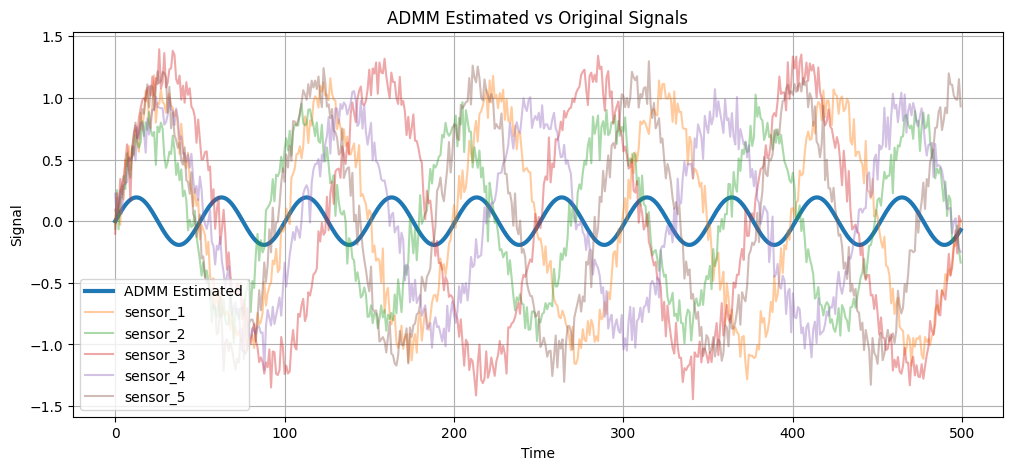

In [71]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('admm_estimated_vs_original.csv')

plt.figure(figsize=(12, 5))
plt.plot(df['t'], df['estimated']*100, label='ADMM Estimated', linewidth=3)

for col in df.columns:
    if 'sensor_' in col:
        plt.plot(df['t'], df[col], alpha=0.4, label=col)

plt.xlabel('Time')
plt.ylabel('Signal')
plt.legend()
plt.title('ADMM Estimated vs Original Signals')
plt.grid(True)
plt.show()


Global weighted temperature estimate: 26.66°C
CSV file saved: sensor_data.csv (ready for CUDA)


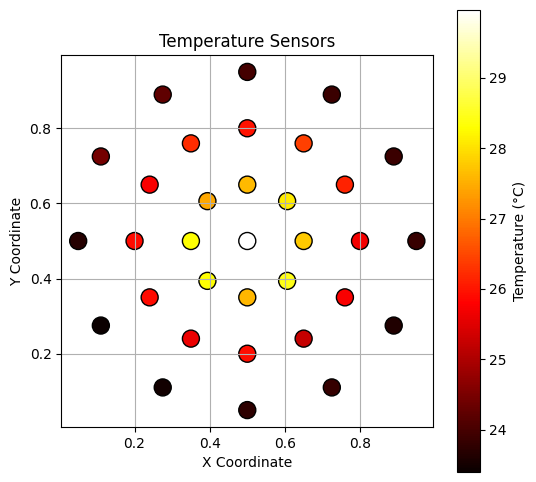

In [119]:
import numpy as np
import matplotlib.pyplot as plt
import csv

# Sensor placement: 1 center + sensors in concentric circles
sensor_locations = [[0.5, 0.5]]  # Center sensor

# Parameters
num_rings = 3
sensors_per_ring = [8, 12, 12]  # Total: 32 + 1 center = 33 sensors
radii = [0.15, 0.30, 0.45]

# Place sensors in rings
for num_sensors, radius in zip(sensors_per_ring, radii):
    angles = np.linspace(0, 2 * np.pi, num_sensors, endpoint=False)
    for angle in angles:
        x = 0.5 + radius * np.cos(angle)
        y = 0.5 + radius * np.sin(angle)
        sensor_locations.append([x, y])

sensor_locations = np.array(sensor_locations)

# Generate synthetic temperatures: center warmer
base_temp = 30
edge_temp = 24
temperatures = []
for loc in sensor_locations:
    distance_to_center = np.linalg.norm(loc - np.array([0.5, 0.5]))
    temp = base_temp - (base_temp - edge_temp) * (distance_to_center / max(radii))
    temp += np.random.normal(0, 0.5)  # Add noise
    temperatures.append(temp)

temperatures = np.array(temperatures)

# Weights: center high, others equal
weights = np.array([10.0] + [1.0] * (len(sensor_locations) - 1))
weights /= weights.sum()

# Global weighted average (not required for CSV, just for info)
global_temperature = np.sum(weights * temperatures)
print(f"Global weighted temperature estimate: {global_temperature:.2f}°C")

# --- CSV for CUDA ---
with open('sensor_data.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['temperature', 'weight'])
    for temp, weight in zip(temperatures, weights):
        writer.writerow([temp, weight])

print("CSV file saved: sensor_data.csv (ready for CUDA)")

# --- Plot for verification ---
plt.figure(figsize=(6, 6))
plt.scatter(sensor_locations[:, 0], sensor_locations[:, 1],
            c=temperatures, cmap='hot', s=150, edgecolors='black')
plt.colorbar(label='Temperature (°C)')
plt.title('Temperature Sensors')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.gca().set_aspect('equal')
plt.grid(True)
plt.show()


In [120]:
%%writefile sensors.cu
#include <iostream>
#include <fstream>
#include <vector>
#include <cmath>
#include <cuda_runtime.h>

#define SENSORS 33
#define ADMM_ITERS 300
#define LOCAL_ITERS 20
#define RHO 1.0f
#define LR 0.01f

// CUDA error check
#define CUDA_CHECK(ans) { gpuAssert((ans), __FILE__, __LINE__); }
inline void gpuAssert(cudaError_t code, const char *file, int line) {
    if (code != cudaSuccess) {
        fprintf(stderr,"GPUassert: %s %s %d\n", cudaGetErrorString(code), file, line);
        exit(code);
    }
}

__global__ void local_update_kernel(float* x_d, float* u_d, float* z_d, float* t_d, float* w_d, float rho, float lr) {
    int idx = threadIdx.x + blockIdx.x * blockDim.x;
    if (idx >= SENSORS) return;

    float t_i = t_d[idx];
    float w_i = w_d[idx];
    float x_i = x_d[idx];
    float u_i = u_d[idx];
    float z = *z_d;

    for (int iter = 0; iter < LOCAL_ITERS; iter++) {
        float grad = 2.0f * w_i * (x_i - t_i) + rho * (x_i - z + u_i);
        x_i -= lr * grad;
    }

    x_d[idx] = x_i;
}

__global__ void dual_update_kernel(float* x_d, float* u_d, float* z_d) {
    int idx = threadIdx.x + blockIdx.x * blockDim.x;
    if (idx >= SENSORS) return;

    float x_i = x_d[idx];
    float z = *z_d;
    float u_i = u_d[idx];

    u_d[idx] = u_i + (x_i - z);
}

void read_csv(const std::string& filename, float* temps, float* weights) {
    std::ifstream file(filename);
    if (!file.is_open()) {
        std::cerr << "Failed to open sensor_data.csv" << std::endl;
        exit(1);
    }
    std::string line;
    getline(file, line); // skip header
    int idx = 0;
    while (getline(file, line) && idx < SENSORS) {
        size_t comma = line.find(',');
        temps[idx] = std::stof(line.substr(0, comma));
        weights[idx] = std::stof(line.substr(comma + 1));
        idx++;
    }
    file.close();
}

float global_z_update(float* x_h, float* u_h, float* weights_h) {
    float weighted_sum = 0.0f;
    float total_weight = 0.0f;
    for (int i = 0; i < SENSORS; i++) {
        float contribution = x_h[i] + u_h[i];
        weighted_sum += weights_h[i] * contribution;
        total_weight += weights_h[i];
    }
    return weighted_sum / total_weight;
}

int main() {
    float temps_h[SENSORS];
    float weights_h[SENSORS];
    float x_h[SENSORS];
    float u_h[SENSORS] = {0};
    float z_h = 25.0f;

    read_csv("sensor_data.csv", temps_h, weights_h);

    for (int i = 0; i < SENSORS; i++) {
        x_h[i] = temps_h[i]; // initialize local estimates
    }

    float *x_d, *u_d, *z_d, *t_d, *w_d;
    CUDA_CHECK(cudaMalloc(&x_d, sizeof(float) * SENSORS));
    CUDA_CHECK(cudaMalloc(&u_d, sizeof(float) * SENSORS));
    CUDA_CHECK(cudaMalloc(&t_d, sizeof(float) * SENSORS));
    CUDA_CHECK(cudaMalloc(&w_d, sizeof(float) * SENSORS));
    CUDA_CHECK(cudaMalloc(&z_d, sizeof(float)));

    dim3 threads(32);
    dim3 blocks((SENSORS + threads.x - 1) / threads.x);

    std::ofstream log_csv("admm_temperature_log.csv");
    log_csv << "iteration,global_temperature\n";

    for (int iter = 0; iter <= ADMM_ITERS; iter++) {
        CUDA_CHECK(cudaMemcpy(x_d, x_h, sizeof(float) * SENSORS, cudaMemcpyHostToDevice));
        CUDA_CHECK(cudaMemcpy(u_d, u_h, sizeof(float) * SENSORS, cudaMemcpyHostToDevice));
        CUDA_CHECK(cudaMemcpy(t_d, temps_h, sizeof(float) * SENSORS, cudaMemcpyHostToDevice));
        CUDA_CHECK(cudaMemcpy(w_d, weights_h, sizeof(float) * SENSORS, cudaMemcpyHostToDevice));
        CUDA_CHECK(cudaMemcpy(z_d, &z_h, sizeof(float), cudaMemcpyHostToDevice));

        local_update_kernel<<<blocks, threads>>>(x_d, u_d, z_d, t_d, w_d, RHO, LR);
        cudaDeviceSynchronize();

        CUDA_CHECK(cudaMemcpy(x_h, x_d, sizeof(float) * SENSORS, cudaMemcpyDeviceToHost));
        CUDA_CHECK(cudaMemcpy(u_h, u_d, sizeof(float) * SENSORS, cudaMemcpyDeviceToHost));

        z_h = global_z_update(x_h, u_h, weights_h);

        CUDA_CHECK(cudaMemcpy(z_d, &z_h, sizeof(float), cudaMemcpyHostToDevice));
        dual_update_kernel<<<blocks, threads>>>(x_d, u_d, z_d);
        cudaDeviceSynchronize();

        if (iter % 10 == 0 || iter == ADMM_ITERS) {
            std::cout << "Iteration " << iter << ": Global Temp = " << z_h << "°C" << std::endl;
        }
        log_csv << iter << "," << z_h << std::endl;
    }

    log_csv.close();
    std::cout << "Saved log to admm_temperature_log.csv" << std::endl;

    cudaFree(x_d);
    cudaFree(u_d);
    cudaFree(t_d);
    cudaFree(w_d);
    cudaFree(z_d);

    return 0;
}



Overwriting sensors.cu


In [121]:
!nvcc -gencode arch=compute_75,code=sm_75 sensors.cu -o sensors
!time ./sensors

Iteration 0: Global Temp = 26.3674°C
Iteration 10: Global Temp = 26.7282°C
Iteration 20: Global Temp = 27.1021°C
Iteration 30: Global Temp = 27.406°C
Iteration 40: Global Temp = 27.6491°C
Iteration 50: Global Temp = 27.8434°C
Iteration 60: Global Temp = 27.9986°C
Iteration 70: Global Temp = 28.1226°C
Iteration 80: Global Temp = 28.2217°C
Iteration 90: Global Temp = 28.3009°C
Iteration 100: Global Temp = 28.3642°C
Iteration 110: Global Temp = 28.4147°C
Iteration 120: Global Temp = 28.4551°C
Iteration 130: Global Temp = 28.4873°C
Iteration 140: Global Temp = 28.5131°C
Iteration 150: Global Temp = 28.5337°C
Iteration 160: Global Temp = 28.5502°C
Iteration 170: Global Temp = 28.5633°C
Iteration 180: Global Temp = 28.5738°C
Iteration 190: Global Temp = 28.5822°C
Iteration 200: Global Temp = 28.5889°C
Iteration 210: Global Temp = 28.5943°C
Iteration 220: Global Temp = 28.5986°C
Iteration 230: Global Temp = 28.602°C
Iteration 240: Global Temp = 28.6047°C
Iteration 250: Global Temp = 28.6069°C

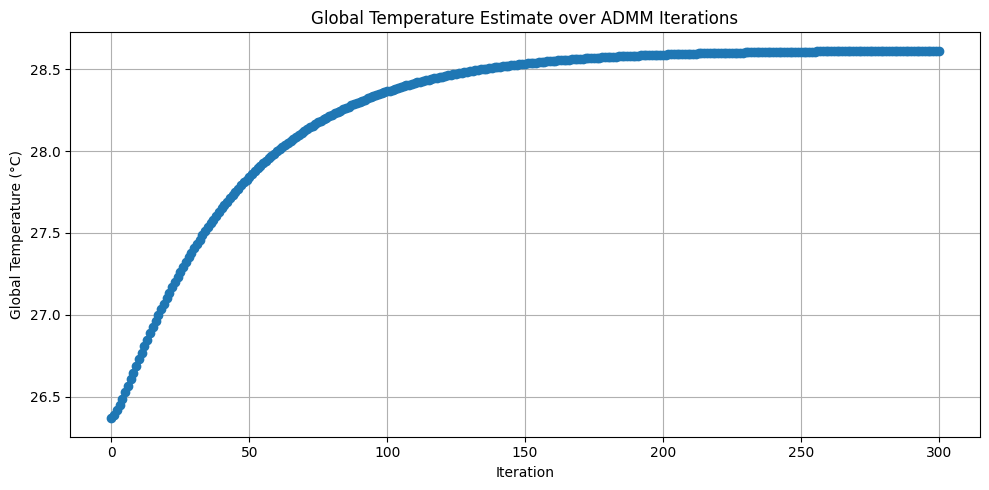

In [122]:
import pandas as pd
import matplotlib.pyplot as plt

# Load ADMM log
log_df = pd.read_csv('admm_temperature_log.csv')

# Plot
plt.figure(figsize=(10, 5))
plt.plot(log_df['iteration'], log_df['global_temperature'], marker='o', linewidth=1.5)
plt.title('Global Temperature Estimate over ADMM Iterations')
plt.xlabel('Iteration')
plt.ylabel('Global Temperature (°C)')
plt.grid(True)
plt.tight_layout()
plt.show()


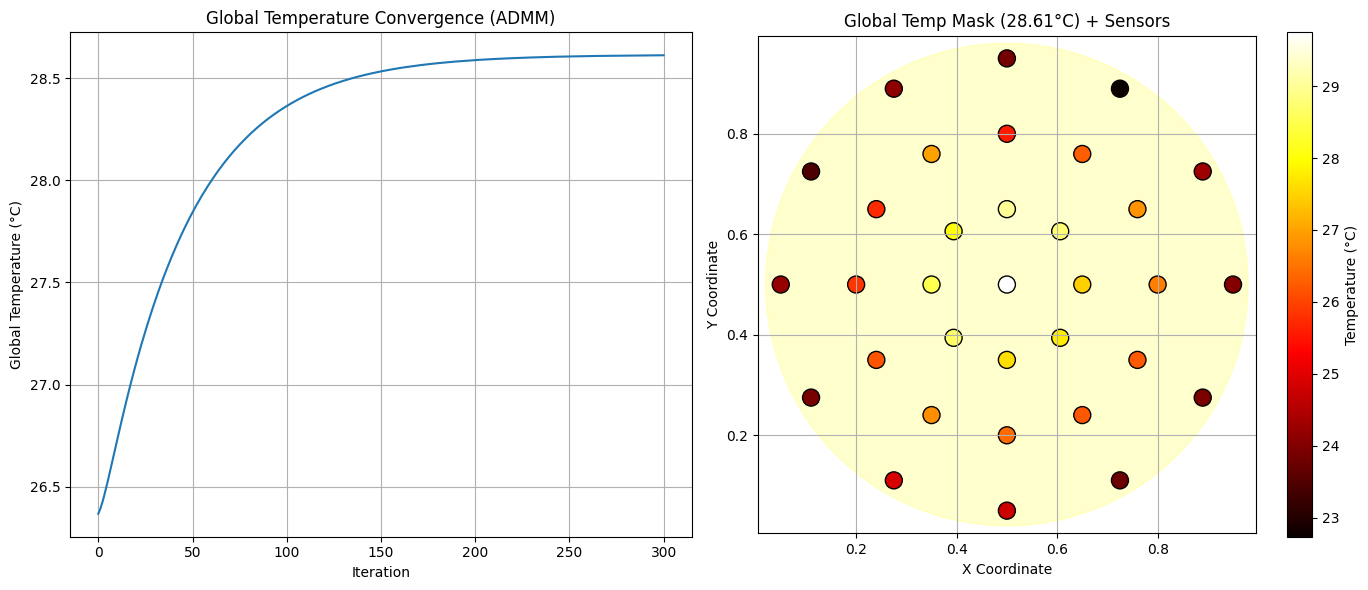

In [126]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Load log
log_df = pd.read_csv('admm_temperature_log.csv')
iterations = log_df['iteration']
global_temps = log_df['global_temperature']

# Load sensor data
sensor_locations = np.loadtxt('sensor_locations.csv', delimiter=',', skiprows=1)
temperatures = np.loadtxt('sensor_temperatures.csv', delimiter=',', skiprows=1).flatten()

final_global_temp = global_temps.iloc[-1]
vmin = min(temperatures.min(), final_global_temp)
vmax = max(temperatures.max(), final_global_temp)

# Create side-by-side figure
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: ADMM convergence log
axs[0].plot(iterations, global_temps, color='tab:blue')
axs[0].set_title('Global Temperature Convergence (ADMM)')
axs[0].set_xlabel('Iteration')
axs[0].set_ylabel('Global Temperature (°C)')
axs[0].grid(True)

# Plot 2: Sensor map with global temperature mask
ax = axs[1]
circle = plt.Circle((0.5, 0.5), 0.48,
                    color=plt.cm.hot((final_global_temp - vmin) / (vmax - vmin)),
                    alpha=0.3, zorder=0)
ax.add_artist(circle)

sc = ax.scatter(sensor_locations[:, 0], sensor_locations[:, 1],
                c=temperatures, cmap='hot', s=150, edgecolors='black',
                vmin=vmin, vmax=vmax, zorder=1)

ax.set_title(f'Global Temp Mask ({final_global_temp:.2f}°C) + Sensors')
ax.set_xlabel('X Coordinate')
ax.set_ylabel('Y Coordinate')
ax.set_aspect('equal')
ax.grid(True)

fig.colorbar(sc, ax=ax, label='Temperature (°C)')

plt.tight_layout()
plt.show()
